## Classifing Text Documents using Multinomial Naive Bayes
In this exercise we will classify the "20 newsgroups" data set using our own naive bayes classifier and compare to the scikit learn built in version.

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon messages posted before and after a specific date.

### The Task
Implement the barebone class provided: `NaiveBayes(BaseEstimator, ClassifierMixin)` and implement its `fit`, `predict` and `predict_proba` methods.

Steps:
* Load the **train** data using `from sklearn.datasets import fetch_20newsgroups`. remove headers, footers and quotes (see documentation)
* Use `sklearn.feature_extraction.text import CountVectorizer` to count words (stop_words='english')
* Use `sklearn.pipeline.make_pipeline` to chain the vectroizer and model.
* note: limit the vocuabolary size if you suffer memory issues
* compare the accuracy over the **test** data. You can use `accuracy_score, classification_report`
* compare to the built in `sklearn.naive_bayes.MultinomialNB`
* compare to `TfidfVectorizer` preprocessing (you can use the built in model for doing the analysis)
* plot the learning curve - is the model in the bias or variance regime (you can use the built in model for doing the analysis)


In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import learning_curve
from collections import Counter
from functools import reduce
import numpy as np
import pandas as pd

In [2]:
class NaiveBayes(BaseEstimator, ClassifierMixin):
    """
    BaseEstimator and ClassifierMixin are imported from sklearn.base
    
    
    Creating the multinomial naive bayes.
    
    """
    
    def fit(self, x, y):
        
        """
        Input: 
        
        x: numpy array, x_train
        y: numpy array, y_train
        both x and y must have the same length.
        
        output: None
        
        
        predicting according to the following formula: 
        P(c|xi) = Count(specific_word_in_class) + 1 / (Num_of_words_in_class + total_vocabulary)
        """
       
        self.prior = Counter(y)  # saves all the priors for each class
    
        for cls, value in self.prior.items():
            self.prior[cls] = value/len(y) # normalize with number of documents
        
        
        
        self.docs_in_class = {} # save each document to its corresponding class in a dicitonary
        for i in range(len(x)):
            if y[i] not in self.docs_in_class:
                self.docs_in_class[y[i]] = list()
            
            self.docs_in_class[y[i]].append(x[i])
            
            
        self.probabilities = {} # saves the P(c|xi)
        for cls, documents in self.docs_in_class.items():
            new_vec = np.zeros(len(documents[0]))
            V = 0
            
            for doc in documents:
                V = len(doc)
                for xi in range(V):
                    
                    new_vec[xi] += doc[xi]
            
            total = sum(new_vec)
            self.probabilities[cls] = (new_vec + 1) / (total + V) # According to formula
            
        

    def predict_log_proba(self, x):
        
        
        """
        Input: x numpy array
        Output: numpy array with the shape: (len(x), number_of_class)
        
        For each document xi we need to calculate the P(class|xi) for each class
        and save it in a vector
        """
        
        proba = []
        
        for i in range(len(x)): # loop thrugh every document
            class_vector = np.zeros(len(self.prior)) # create the class vector that holds their probabilities
            
            for cls, pri in self.prior.items(): # loop for each class
                
                # formula: P(class|xi) = log(prior) + sigma(P(word|class)^num_word_in_class)
                
                prob_power = np.power(self.probabilities[cls], x[i])
                prob_power = np.log(prob_power[prob_power != 0])
                prob = np.log(pri) + np.sum(prob_power)
                
                class_vector[int(cls)] = prob 
            proba.append(class_vector)
        return proba
                
        
    def predict(self, x):
        
        """
        Input: x numpy array
        Output: Numpy array with the shape: (len(x)) -> the classification of x of our model
        """
        
        proba = self.predict_log_proba(x) # fetch all log probabilities for each document
   
        predictions = []
        for class_vector in proba: 
            cls = np.argmax(class_vector) # find the MLE for each document -> prediction
            predictions.append(cls)
            

        return predictions
    
        

In [3]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

x_train = newsgroups_train.data
y_train = newsgroups_train.target

x_test = newsgroups_test.data
y_test = newsgroups_test.target

In [4]:
# Count Vectorizer
# Our model

pipe_our = make_pipeline(
    CountVectorizer(
    stop_words='english',max_features=3000), 
    FunctionTransformer(lambda x: x.toarray()),  # We use the funciton transformer to convert our data to numpy arrays               
    NaiveBayes()) # Our model: Naive Bayes
pipe_our.fit(x_train, y_train)
y_pred_count_our = pipe_our.predict(x_test)


# Scikit model
pipe_their = make_pipeline(CountVectorizer(
    stop_words='english',max_features=3000),
    FunctionTransformer(lambda x: x.toarray()),                
    MultinomialNB()) # thier model: MultinomialNB
pipe_their.fit(x_train, y_train)
y_pred_count_their = pipe_their.predict(x_test)



In [5]:
# tfidf Vectorizer
# Our model

pipe_our = make_pipeline(TfidfVectorizer(
    stop_words='english',max_features=3000),
    FunctionTransformer(lambda x: x.toarray()),                
    NaiveBayes()) 
pipe_our.fit(x_train, y_train)
y_pred_tfidf_our = pipe_our.predict(x_test)


# Scikit model
pipe_their = make_pipeline(TfidfVectorizer(
    stop_words='english',max_features=3000),
    FunctionTransformer(lambda x: x.toarray()),                
    MultinomialNB()) 
pipe_their.fit(x_train, y_train)
y_pred_tfidf_their = pipe_their.predict(x_test)



In [6]:
print("Count vectorizer")
print(f"Our accuracy score:    {round(accuracy_score(y_test, y_pred_count_our), 13)}")
print(f"Their accuracy score:  {round(accuracy_score(y_test, y_pred_count_their), 13)}")
print()
print("Tfidf vectorizer")
print(f"Our accuracy score:    {round(accuracy_score(y_test, y_pred_tfidf_our), 13)}")
print(f"Their accuracy score:  {round(accuracy_score(y_test, y_pred_tfidf_their), 13)}")

Count vectorizer
Our accuracy score:    0.5569569835369
Their accuracy score:  0.5574880509825

Tfidf vectorizer
Our accuracy score:    0.6233404142326
Their accuracy score:  0.6233404142326


#### We got almost idencitcal score as the native scikit model!
Now we will plot the learning curve.

In [7]:
import matplotlib.pyplot as plt

train_sizes, train_scores, validation_scores  = learning_curve(
    pipe_their, 
    x_train,
    y_train,
    train_sizes = np.linspace(0.1, 1.0, 10), #we take 10 points of measure
    

)

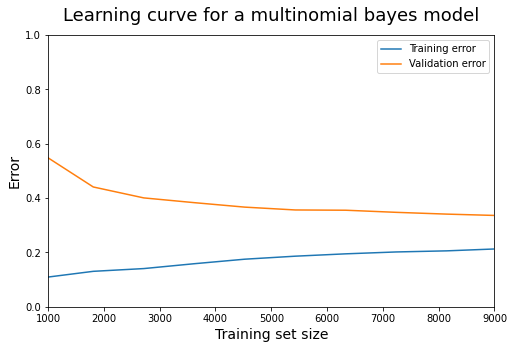

In [9]:
train_scores_mean = 1 - train_scores.mean(axis = 1)  # substract 1 because we want to see the error
validation_scores_mean = 1 - validation_scores.mean(axis = 1)   # substract 1 because we want to see the error

plt.figure(figsize = (8,5))

plt.plot(train_sizes, train_scores_mean, label = 'Training error') #plot the training error
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error') #plot the validation error

plt.ylabel('Error', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
title = 'Learning curve for a multinomial bayes model'
plt.title(title, fontsize = 18, y = 1.03)
plt.ylim(0,1)
plt.xlim(1000,9000)
plt.legend()
plt.show()

This model has high variacne and low bias becuase of the shape of the graph.
The training error and then cross-validation error are quite low therfore it is low bias.
The differences between the training error and cross-validation error are quite sparse therfore it is high variance.